# Finding RNAfish spots in 256x256 images using Unet, Conv2d

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from scipy.optimize import curve_fit
from sklearn import cluster, mixture
from PIL import Image
import random
import utils
import glob
from sklearn.manifold import TSNE
from sklearn.neighbors import kneighbors_graph

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Get data

Load data from file

In [2]:
xrng=np.linspace(0,1,512)

In [3]:
training_data=np.asarray([np.random.choice([0,1], p=[0.5,0.5])*np.random.uniform(low=0.1,high=0.3)*np.exp(-(xrng-np.random.uniform(low=0, high=1))**2/2/np.random.uniform(low=0.01, high=0.1)**2)+np.random.uniform(low=0.3, high=0.5)*np.random.uniform(size=512)+np.random.uniform(low=0.1, high=0.5) for j in range(0,5000)])
training_data=np.reshape(training_data, [5000,512,1,1])
validation_data=training_data

# Design network

Define a function to create a convolutional layer, including conv, relu, maxpool, that can be called multiple times

In [4]:
tf.reset_default_graph()
#Input and output
x=tf.placeholder(dtype=tf.float32, shape=[None, 512,1,1], name='x')
y=tf.placeholder(dtype=tf.float32, shape=[None, 512,1,1], name='y')

xr=x
yr=y

base_scaler=32

#Going down
A1=(tf.layers.conv2d(xr, base_scaler, [5,1], padding='SAME'))
A2=(tf.layers.conv2d(A1, base_scaler, [3,1], padding='SAME'))

B0=tf.nn.max_pool(A2, ksize=[1,2,1,1], strides=[1,2,1,1], padding='SAME')
B1=(tf.layers.conv2d(B0, 2*base_scaler, [3,1], padding='SAME'))
B2=(tf.layers.conv2d(B1, 2*base_scaler, [3,1], padding='SAME'))

C0=tf.nn.max_pool(B2, ksize=[1,2,1,1], strides=[1,2,1,1], padding='SAME')
C1=(tf.layers.conv2d(C0, 4*base_scaler, [3,1], padding='SAME'))
C2=(tf.layers.conv2d(C1, 4*base_scaler, [3,1], padding='SAME'))

D0=tf.nn.max_pool(C2, ksize=[1,2,1,1], strides=[1,2,1,1], padding='SAME')
D1=(tf.layers.conv2d(D0, 8*base_scaler, [3,1], padding='SAME'))
D2=(tf.layers.conv2d(D1, 8*base_scaler, [3,1], padding='SAME'))

E0=tf.nn.max_pool(D2, ksize=[1,2,1,1], strides=[1,2,1,1], padding='SAME')
E1=(tf.layers.conv2d(E0, 16*base_scaler, [3,1], padding='SAME'))
E2=(tf.layers.conv2d(E1, 16*base_scaler, [3,1], padding='SAME'))

F0=tf.nn.max_pool(E2, ksize=[1,2,1,1], strides=[1,2,1,1], padding='SAME')
F1=(tf.layers.conv2d(F0, 32*base_scaler, [3,1], padding='SAME'))
F2=(tf.layers.conv2d(F1, 32*base_scaler, [3,1], padding='SAME'))


#Fully connected
G1=tf.reshape(F2,[-1,16*1*32*base_scaler])
G2=(tf.layers.dense(G1,30))
latent=tf.layers.dense(G2,8)
G4=tf.layers.dense(latent,16*1*16)
G5=tf.reshape(G4,[-1,16,1,16])

#Coming up
EE0=tf.layers.conv2d_transpose(G5, 8*base_scaler, kernel_size=[3,1], strides=[2, 1], padding='SAME')
EE1=EE0
EE2=(tf.layers.conv2d(EE1, 16*base_scaler, [3,1], padding='SAME'))
EE3=(tf.layers.conv2d(EE2, 16*base_scaler, [3,1], padding='SAME'))

DD0=tf.layers.conv2d_transpose(EE2, 8*base_scaler, kernel_size=[3,1], strides=[2, 1], padding='SAME')
DD1=DD0
DD2=(tf.layers.conv2d(DD1, 8*base_scaler, [3,1], padding='SAME'))
DD3=(tf.layers.conv2d(DD2, 8*base_scaler, [3,1], padding='SAME'))

CC0=tf.layers.conv2d_transpose(DD3, 4*base_scaler, kernel_size=[3,1], strides=[2, 1], padding='SAME')
CC1=CC0
CC2=(tf.layers.conv2d(CC1, 4*base_scaler, [3,1], padding='SAME'))
CC3=(tf.layers.conv2d(CC2, 4*base_scaler, [3,1], padding='SAME'))

BB0=tf.layers.conv2d_transpose(CC3, 2*base_scaler, kernel_size=[3,1], strides=[2, 1], padding='SAME')
#BB0=tf.contrib.layers.conv2d_transpose(C2, 2*base_scaler, kernel_size=[3,3], stride=[2, 2], padding='SAME')
BB1=BB0
BB2=(tf.layers.conv2d(BB1, 2*base_scaler, [3,1], padding='SAME'))
BB3=(tf.layers.conv2d(BB2, 2*base_scaler, [3,1], padding='SAME'))

AA0=tf.layers.conv2d_transpose(BB3, base_scaler, kernel_size=[3,1], strides=[2, 1], padding='SAME')
AA1=AA0
AA2=(tf.layers.conv2d(AA1, base_scaler, [3,1], padding='SAME'))
AA3=(tf.layers.conv2d(AA2, base_scaler, [3,1], padding='SAME'))

#logits=utils.leaky_relu(tf.layers.conv2d(AA3, 3, [1,1], padding='SAME'))
logits=tf.nn.relu(tf.layers.conv2d(AA3, 1, [1,1], padding='SAME'))
probs=tf.tanh(logits, name='probabilities')
diff=tf.subtract(probs, yr)
LSQ=tf.multiply(diff,diff)
#Added this to make the outlines more potent in error function
#OutError, MaskError=tf.split(LSQ, [1,1], 3)
#loss=1*tf.reduce_mean(OutError)+0.1*tf.reduce_mean(MaskError)
loss=tf.reduce_mean(LSQ, name='error')

train_op=tf.train.AdamOptimizer(learning_rate=0.0001, name='trainer').minimize(loss)

# Training on easy set

0
Training loss:  0.28656438
(20, 512, 1, 1)
Validation loss:  0.32998472


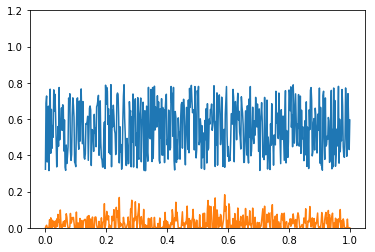

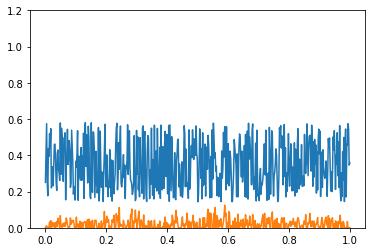

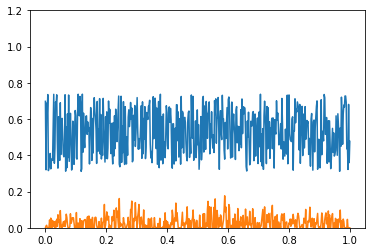

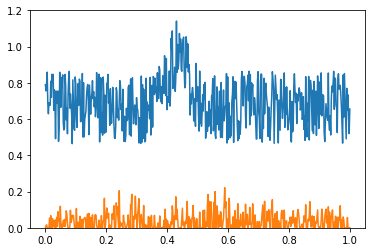

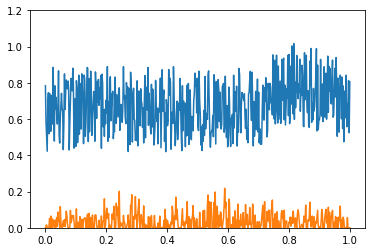

100
Training loss:  0.016036395
(20, 512, 1, 1)
Validation loss:  0.0147099765


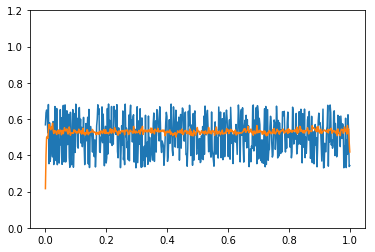

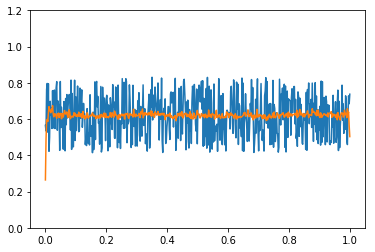

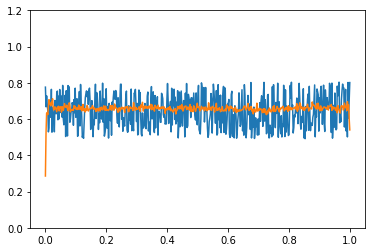

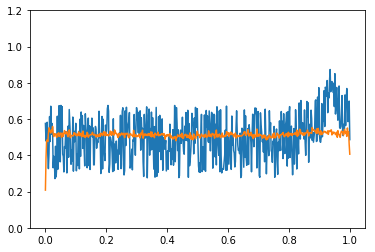

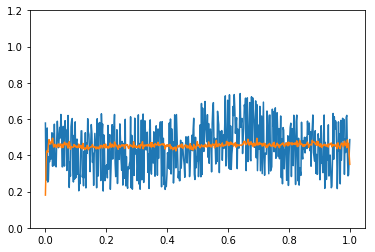

200
Training loss:  0.014067745
(20, 512, 1, 1)
Validation loss:  0.014259612


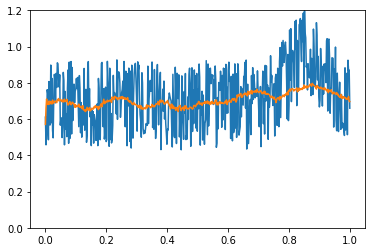

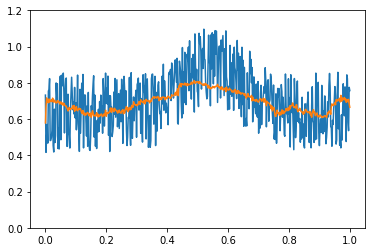

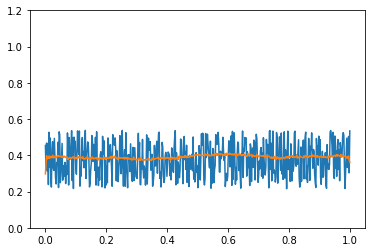

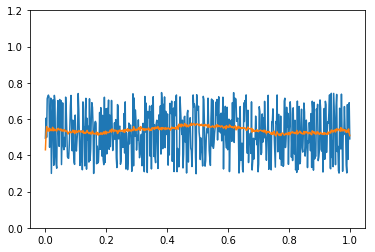

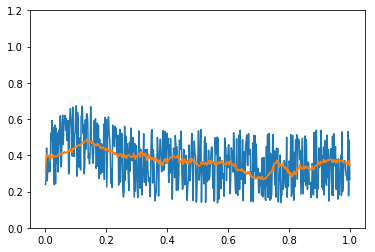

300
Training loss:  0.013634094
(20, 512, 1, 1)
Validation loss:  0.013479354


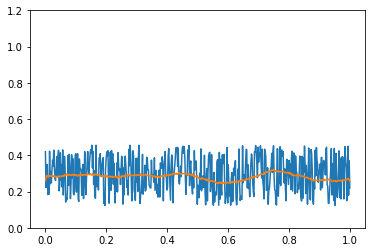

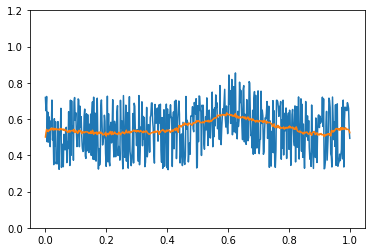

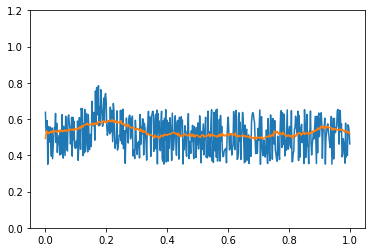

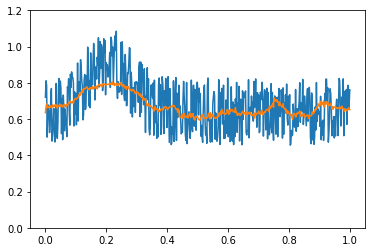

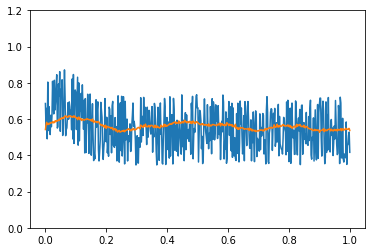

400
Training loss:  0.0141275935
(20, 512, 1, 1)
Validation loss:  0.012352202


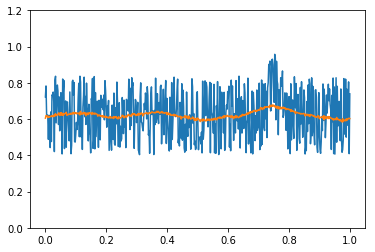

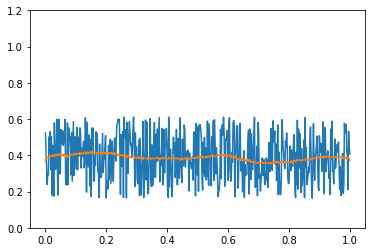

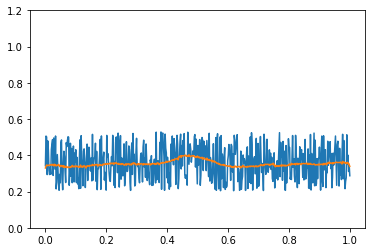

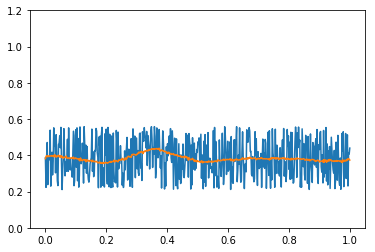

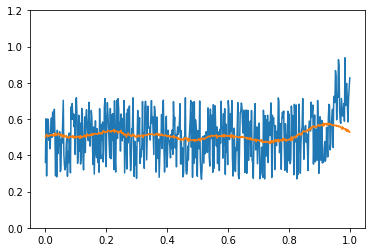

500
Training loss:  0.01472823
(20, 512, 1, 1)
Validation loss:  0.014171483


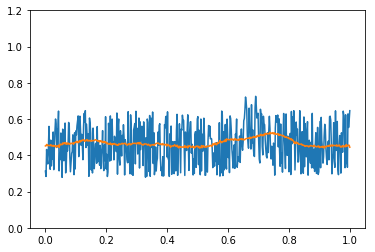

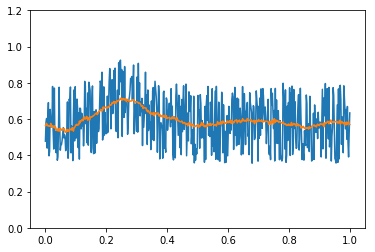

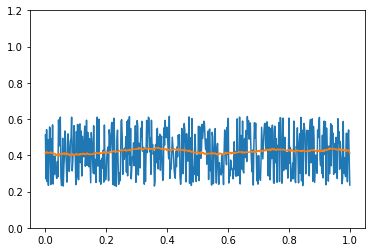

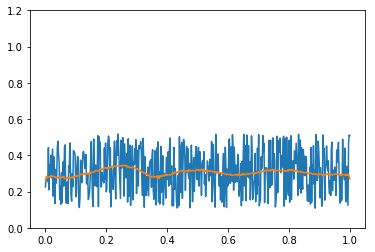

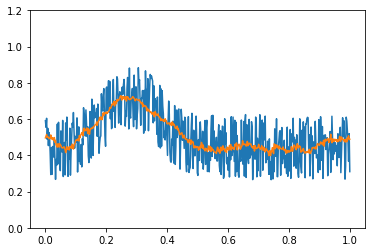

600
Training loss:  0.013823538
(20, 512, 1, 1)
Validation loss:  0.014517719


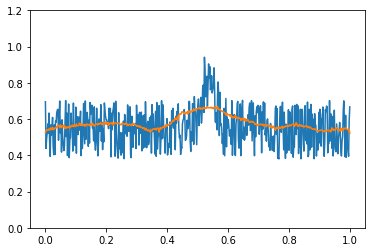

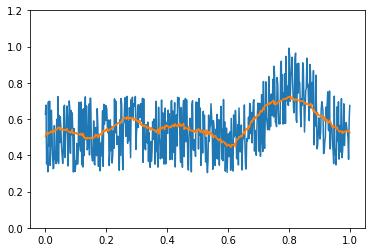

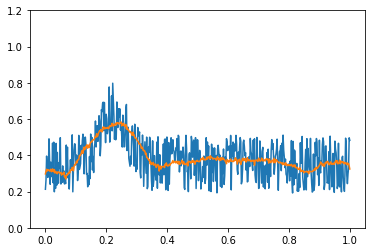

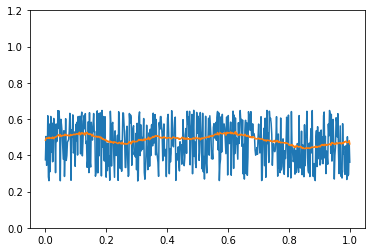

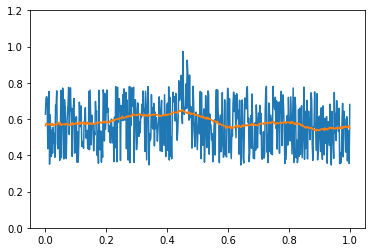

700
Training loss:  0.013767903
(20, 512, 1, 1)
Validation loss:  0.013400351


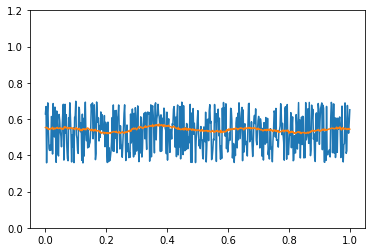

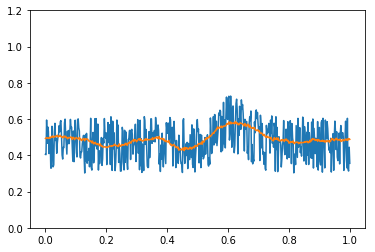

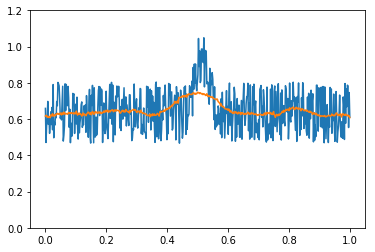

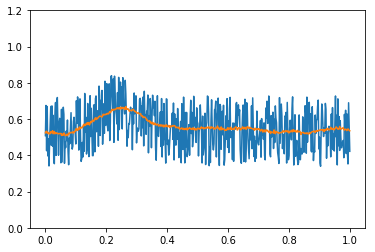

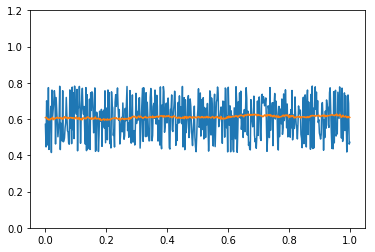

800
Training loss:  0.01466275
(20, 512, 1, 1)
Validation loss:  0.015482569


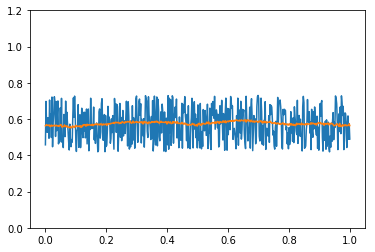

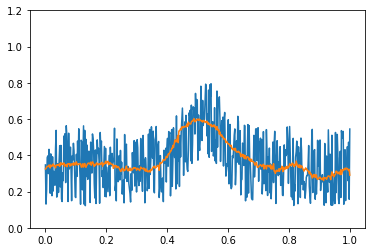

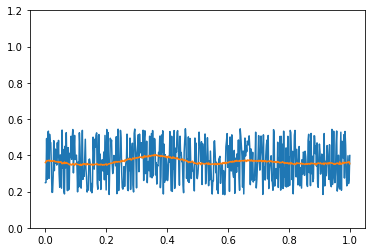

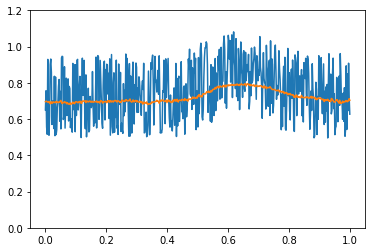

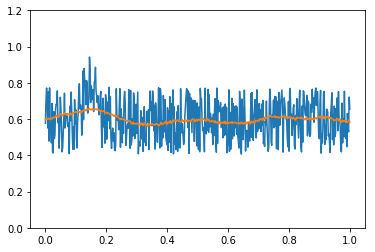

900
Training loss:  0.014204328
(20, 512, 1, 1)
Validation loss:  0.013698056


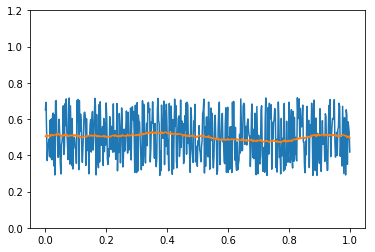

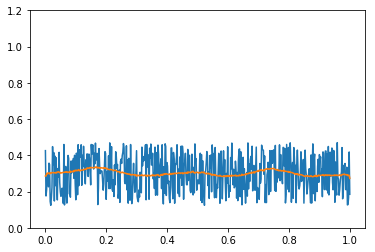

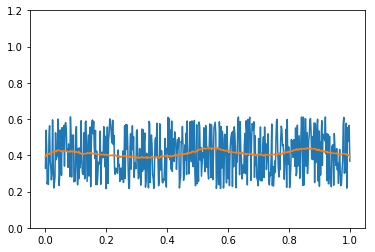

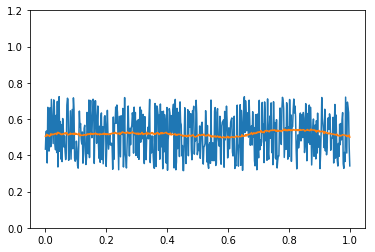

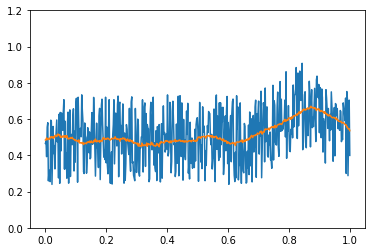

1000
Training loss:  0.01326216
(20, 512, 1, 1)
Validation loss:  0.01280888


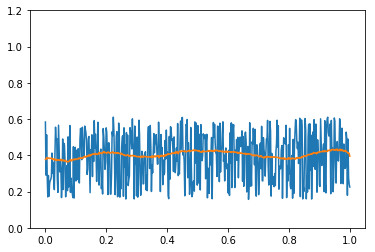

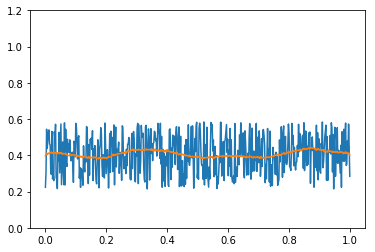

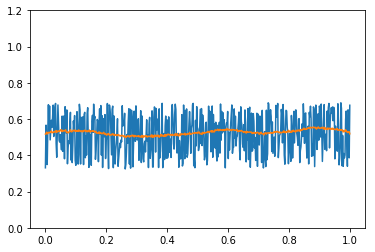

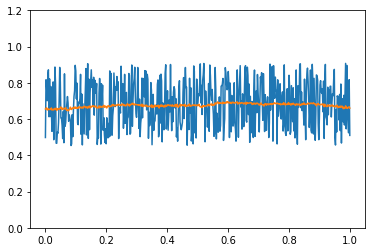

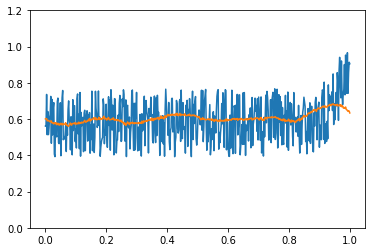

1100
Training loss:  0.011843765
(20, 512, 1, 1)
Validation loss:  0.013354121


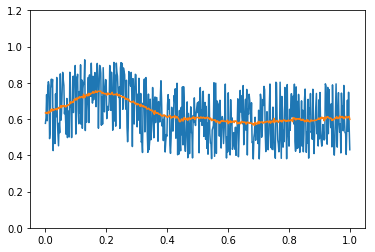

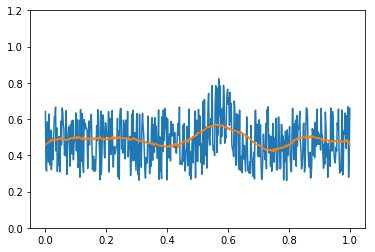

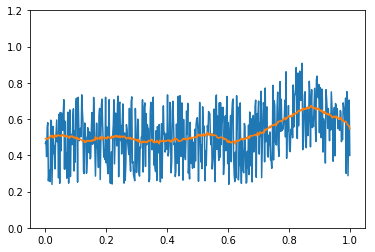

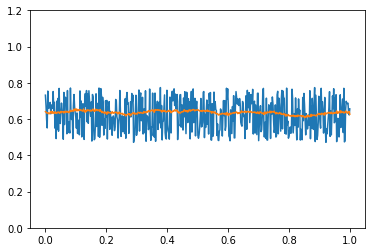

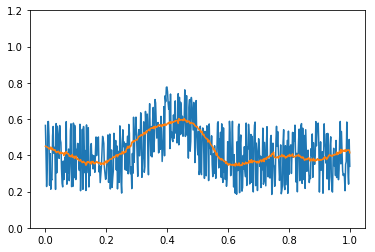

1200
Training loss:  0.013778207
(20, 512, 1, 1)
Validation loss:  0.013034222


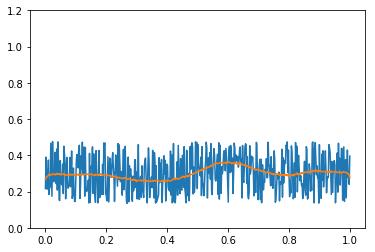

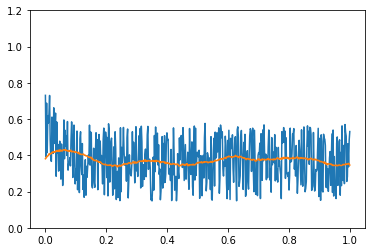

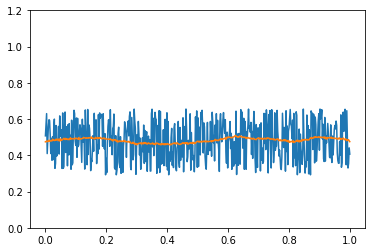

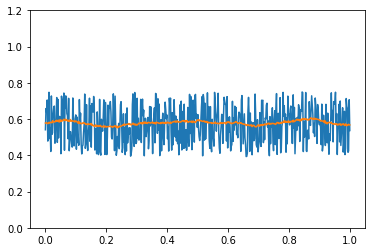

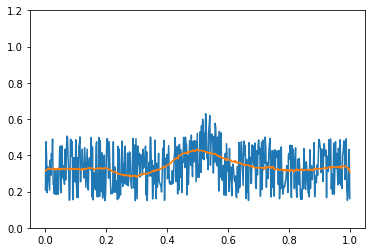

1300
Training loss:  0.013301512
(20, 512, 1, 1)
Validation loss:  0.012828879


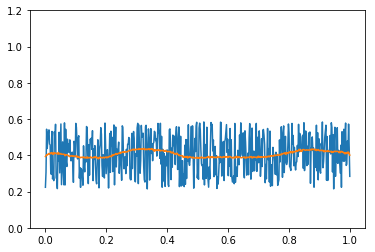

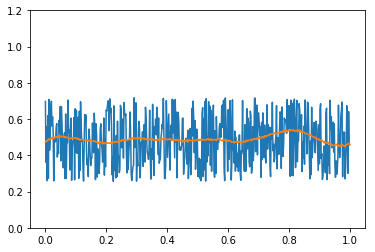

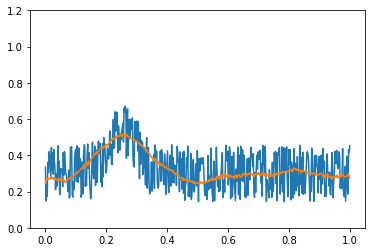

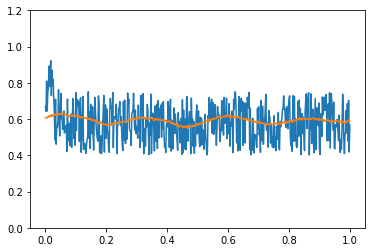

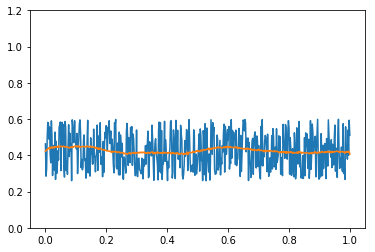

1400
Training loss:  0.013912529
(20, 512, 1, 1)
Validation loss:  0.014175789


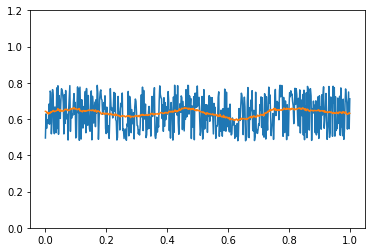

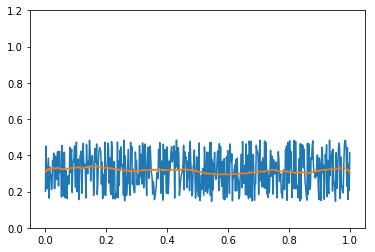

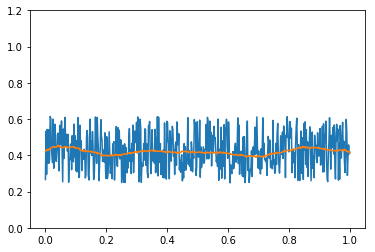

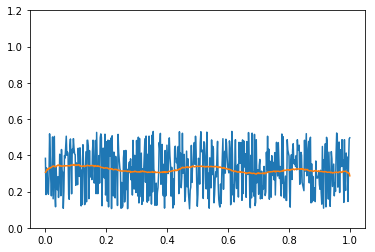

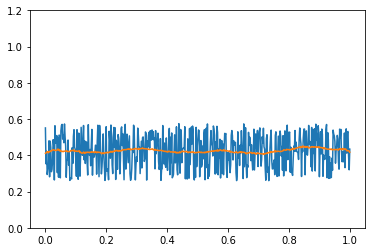

1500
Training loss:  0.013550868
(20, 512, 1, 1)
Validation loss:  0.014190887


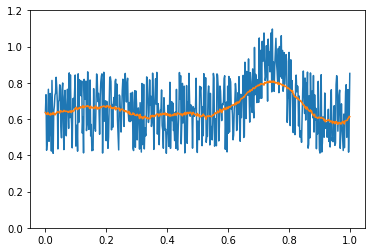

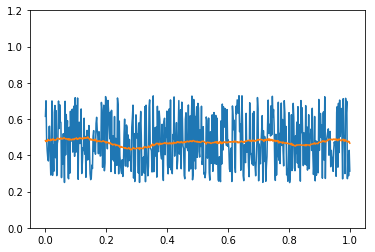

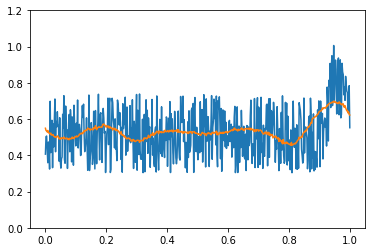

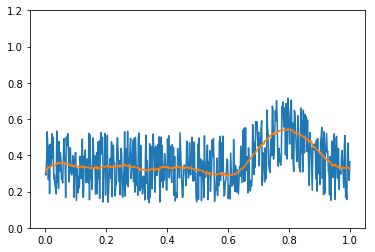

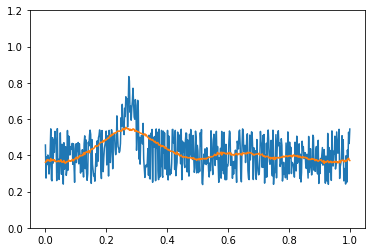

1600
Training loss:  0.013747578
(20, 512, 1, 1)
Validation loss:  0.012515187


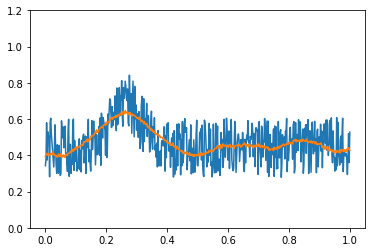

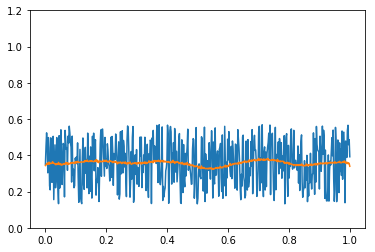

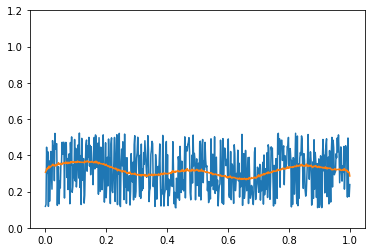

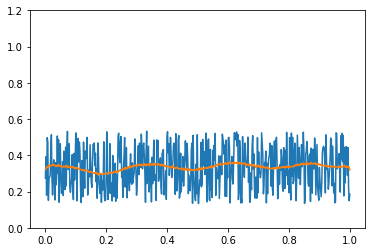

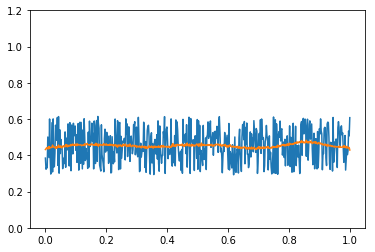

1700
Training loss:  0.0136114685
(20, 512, 1, 1)
Validation loss:  0.01357734


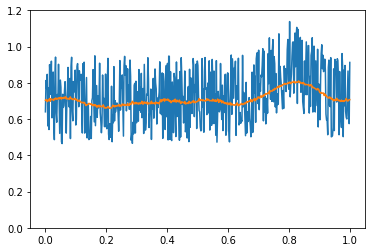

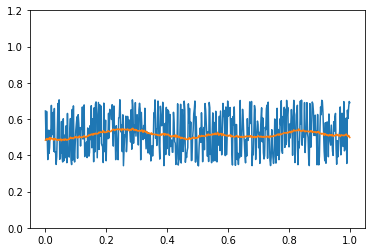

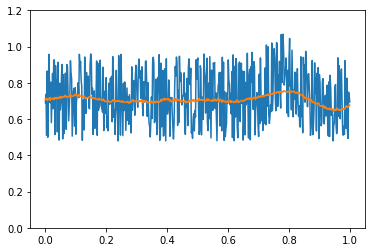

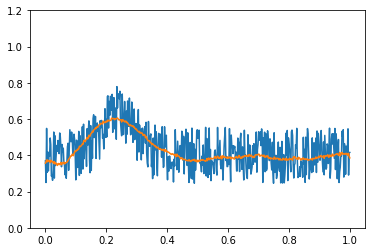

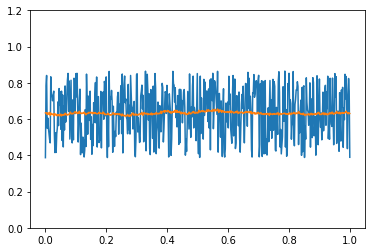

KeyboardInterrupt: 

In [5]:
tf.set_random_seed(123456)
sess=tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(2000):
    idx=np.random.choice(training_data.shape[0], replace=False, size=[50])
    cur_train=training_data[idx,:,:,:]
    _,results, losses=sess.run([train_op, probs, loss], feed_dict={x:cur_train, y:cur_train})
    if (i%100==0):
        print(i)
        print("Training loss: ",losses)
        idx=np.random.choice(validation_data.shape[0], replace=False, size=[20])
        #idx=range(0,300)
        sub_validation_data=validation_data[idx, :,:,:]
        results, losses, a,c,cc=sess.run([probs, loss, A1,C2,CC2], feed_dict={x:sub_validation_data, y:sub_validation_data})
        print(results.shape)
        print("Validation loss: ",losses)
        for ti in range (0,5):
            #utils.plot_4x1(sub_validation_data[ti,:,:,:], sub_validation_data[ti,:,:,:], results[ti,:,:,:], results[ti,:,:,:])
            plt.plot(xrng, sub_validation_data[ti,:,0,0], xrng, results[ti,:,0,0])
            plt.gca().set_ylim([0,1.2])
            plt.show()
#saver = tf.train.Saver()
#saver.save(sess, data+'Model')

# Save

# Process new datafiles using trained network

Load the network that works best

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.004s...
[t-SNE] Computed neighbors for 5000 samples in 0.347s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.141773
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.184784
[t-SNE] Error after 300 iterations: 2.026815


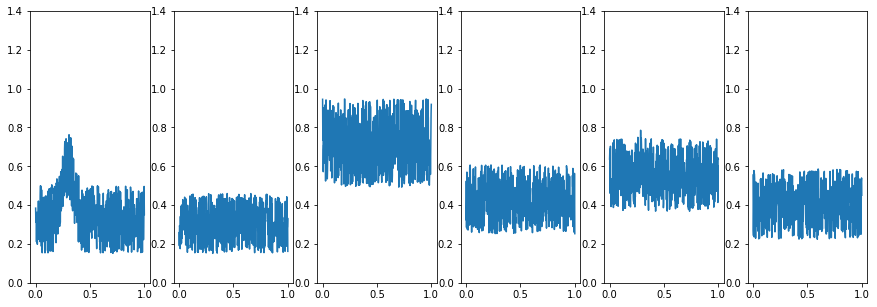

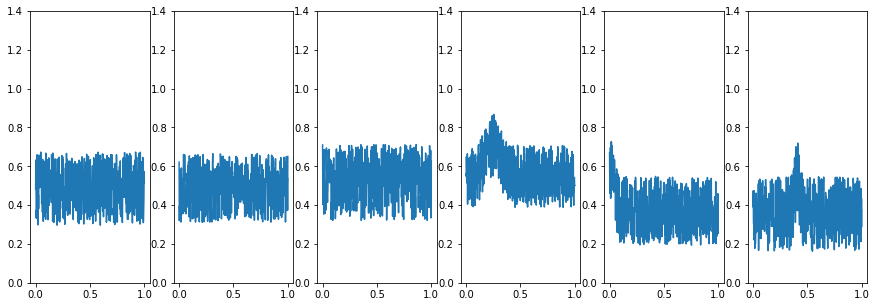

In [6]:
#current_data=test_data[[3,6,44,59,92,100,111,115,119,147,148],:,:,:]
#current_data=test_data
current_data=training_data
results, losses, a, lat=sess.run([probs, loss, A1,latent], feed_dict={x:current_data, y:current_data})
clusters=2
tsne = TSNE(n_components=clusters, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(lat)
knn_graph = kneighbors_graph(tsne_results, 10, include_self=False)
rtnAgg=cluster.AgglomerativeClustering(n_clusters=clusters, connectivity=knn_graph, linkage='ward').fit_predict(tsne_results)
#rtnAgg=cluster.SpectralClustering(n_clusters=clusters).fit_predict(tsne_results)
for c in range(0,clusters):
    subset=current_data[rtnAgg==c,:,:,:]
    idx=np.random.choice(subset.shape[0], replace=True, size=[6])
    plt.subplots(1,6,figsize=(15,5))
    for ss in range(1,7):
        
        plt.subplot(1,6,ss)
        #plt.plot(xrng,current_data[idx[ss-1],:,0,0], xrng, results[idx[ss-1],:,0,0])
        plt.plot(xrng,current_data[idx[ss-1],:,0,0])
        plt.gca().set_ylim([0,1.4])
    plt.show()
        
    

In [73]:
tsne_results.shape

(5000, 2)

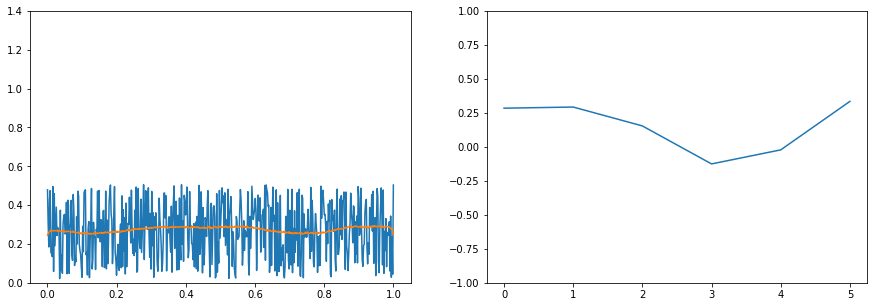

In [57]:

for tt in range(0,1):
    plt.subplots(1,2,figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(xrng,current_data[tt,:,0,0], xrng, results[tt,:,0,0])
    plt.gca().set_ylim([0,1.4])
    plt.subplot(1,2,2)
    plt.plot(lat[tt,:])
    plt.gca().set_ylim([-1,1])

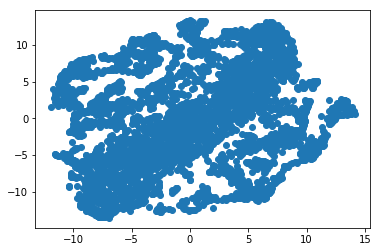

In [7]:
plt.scatter(tsne_results[:,0], tsne_results[:,1])

In [39]:
sat=np.where(np.asarray( (tsne_results[:,0]<-5)&(tsne_results[:,0]<3)&(tsne_results[:,1]<0)&(tsne_results[:,1]<-5) ) )[0]

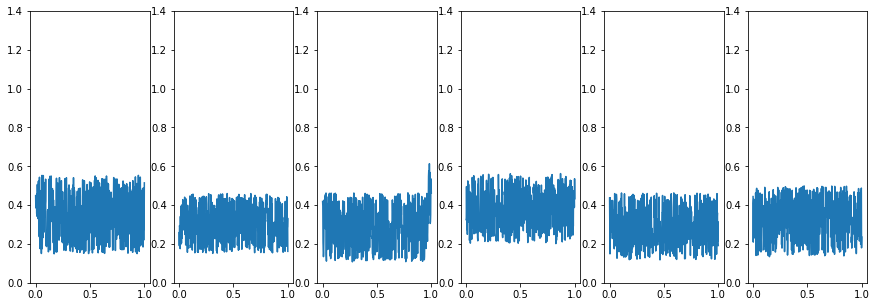

In [43]:
plt.subplots(1,6,figsize=(15,5))
for ss in range(1,7):
        
        plt.subplot(1,6,ss)
        #plt.plot(xrng,current_data[idx[ss-1],:,0,0], xrng, results[idx[ss-1],:,0,0])
        plt.plot(xrng,current_data[sat[ss+10],:,0,0])
        plt.gca().set_ylim([0,1.4])

4590
4529
4443
3755
1490
981
20
3969


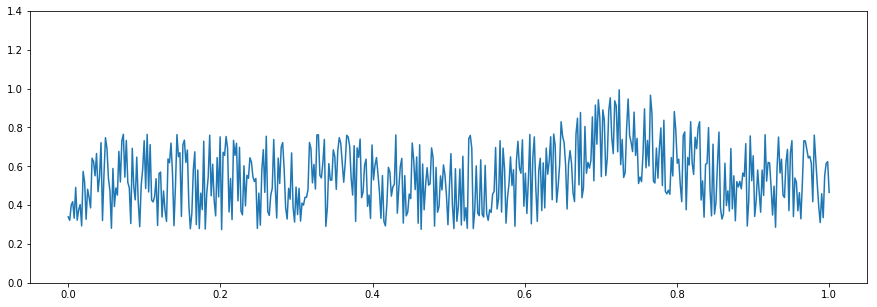

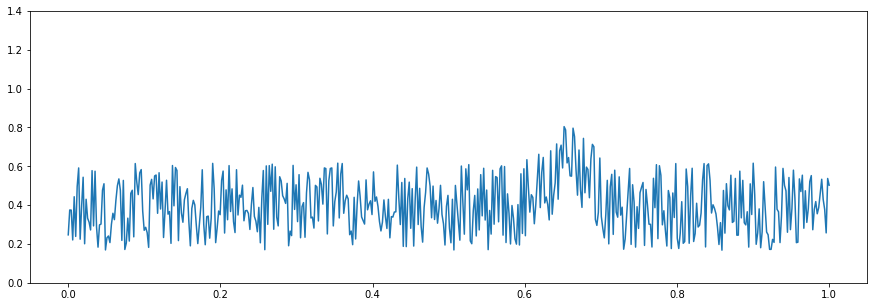

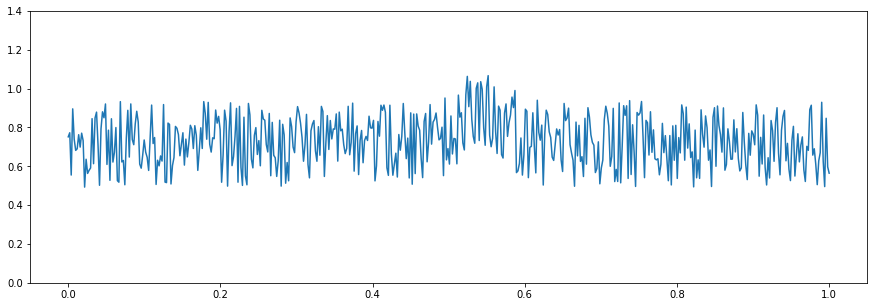

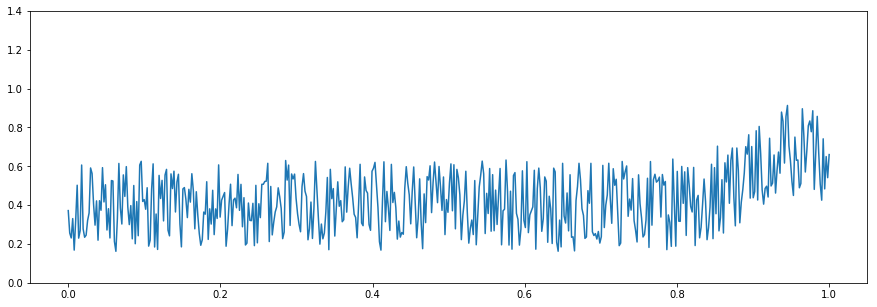

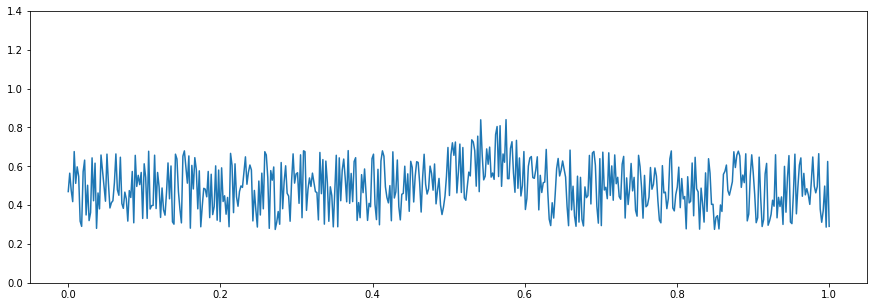

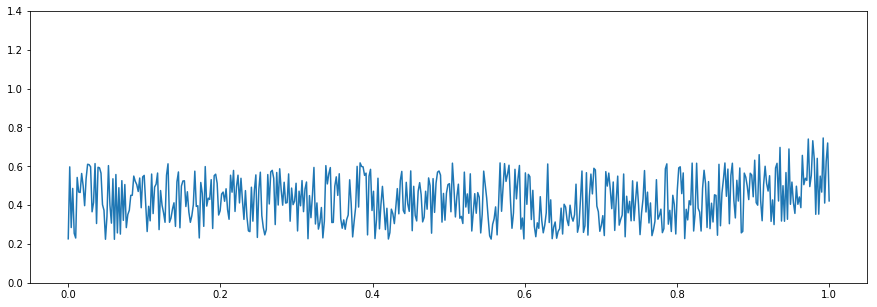

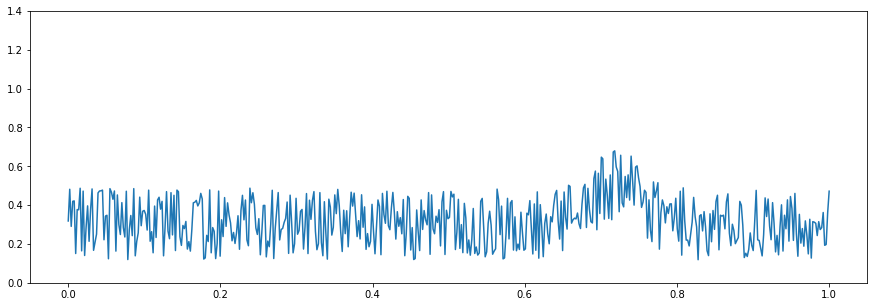

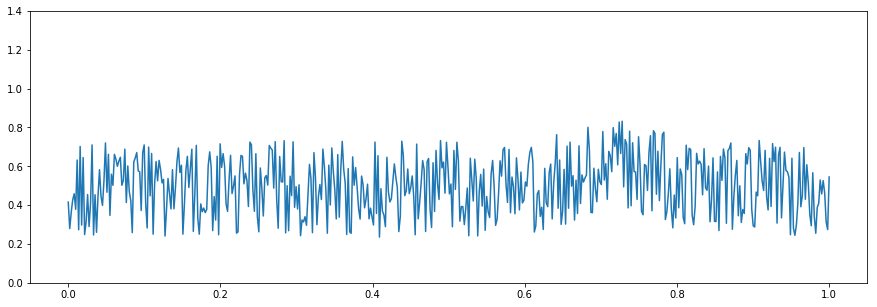

In [11]:
for tt in np.random.choice(sat, size=8):
    print(tt)
    plt.subplots(1,2,figsize=(15,5))
    plt.subplot(1,1,1)
    #plt.plot(xrng,current_data[tt,:,0,0], xrng, results[tt,:,0,0])
    plt.plot(xrng,current_data[tt,:,0,0])
    plt.gca().set_ylim([0,1.4])
    #plt.subplot(1,2,2)
    #plt.plot(lat[tt,:])
    #plt.gca().set_ylim([-1,1])

(array([37., 10., 14., 21., 37., 34., 28., 33.,  7., 27., 18., 18., 22.,
         5., 10., 28.,  1., 15., 40.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 19 Patch objects>)

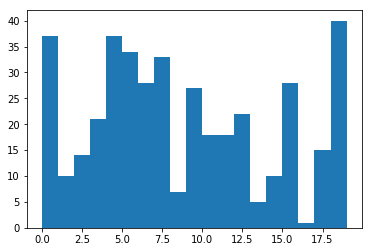

In [31]:
plt.hist(rtnAgg, bins=range(0,20))